## Imports

In [1]:
import glob
import os
import random
import torch
import torchvision

import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch import nn
from typing import Tuple, Any
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
import torchvision.models as models

In [2]:
os.environ["KMP_DUPLICATE_LIB_OK"] = (
    "True"  # A fix for some strange matplotlib error
)

In [3]:
MODELS_DIR = "models"
DATASET_DIR = "dataset"

## Set seed

In [4]:
seed = 44
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

## Load data

In [5]:
def load_data(dataset_folder_path: str) -> Tuple[pd.DataFrame, torch.Tensor]:
    """
    Returns pd.Dataframe with targets and torch.tensor with photo data
    """
    df = None
    photos = []
    curr_photo_id = 0
    for csv_file in glob.glob(f"{dataset_folder_path}/*.csv"):
        folder_df = pd.read_csv(
            csv_file, header=None, names=["filename", "forward", "left"]
        )
        photo_folder_name = os.path.splitext(csv_file)[0]
        folder_df["folder_name"] = photo_folder_name
        photo_paths = glob.glob(f"{photo_folder_name}/*.jpg")
        for photo_path in photo_paths:
            photos.append(torchvision.io.read_image(photo_path))
        folder_df["photo_id"] = folder_df.index + curr_photo_id
        curr_photo_id += folder_df.index.max() + 1
        if df is None:
            df = folder_df
        else:
            df = pd.concat([df, folder_df], axis=0)
    df = df.set_index("photo_id")
    photos = torch.from_numpy(np.array(photos))
    return df, photos

def classify_left_value(left):
    if left >= 0.005:
        return 1
    elif left <= -0.005:
        return -1
    else:
        return 0

df, photos = load_data(DATASET_DIR)

df['left_class'] = df['left'].apply(classify_left_value)

df['left_class'].value_counts()

left_class
 0    4202
-1    3382
 1    3382
Name: count, dtype: int64

In [6]:
df.describe()

,filename,forward,left,left_class
count,10966.000000,10966.000000,10966.000000,10966.000000
mean,1532.203356,0.874310,0.000000,0.000000
std,2092.217741,0.213113,0.761005,0.785412
min,5.000000,-0.992188,-1.000000,-1.000000
25%,271.000000,0.789062,-0.992188,-1.000000
50%,523.000000,0.984375,0.000000,0.000000
75%,1752.000000,1.000000,0.992188,1.000000
max,7583.000000,1.000000,1.000000,1.000000


In [7]:
df

,filename,forward,left,folder_name,left_class
photo_id,,,,,
0,24,0.039062,0.000000,dataset\1652875851.3497071,0
1,25,0.210938,0.000000,dataset\1652875851.3497071,0
2,26,0.390625,0.000000,dataset\1652875851.3497071,0
3,27,0.421875,0.000000,dataset\1652875851.3497071,0
4,28,0.421875,0.000000,dataset\1652875851.3497071,0
...,...,...,...,...,...
10961,7579,0.398438,-0.992188,dataset\flipped,-1
10962,7580,0.367188,-0.992188,dataset\flipped,-1
10963,7581,0.367188,-0.992188,dataset\flipped,-1


## Create flip of every image that suggests rotation.

In [8]:
# import torchvision.transforms.functional as F
# from PIL import Image
# import torchvision.transforms as transforms

# def horizontal_flip(df: pd.DataFrame, photos: torch.Tensor):
#     output_csv_path = f'{DATASET_DIR}\\flipped.csv'
#     flipped_data = []
#     for idx, row in df.iterrows():
#         left_class = row['left_class']
#         if left_class in [1, -1]:
#             img = photos[idx]
#             flipped_img = F.hflip(img)

#             img_filename = f'{DATASET_DIR}\\flipped\\{idx}.jpg'
#             os.makedirs(os.path.dirname(img_filename), exist_ok=True)  # Ensure the directory exists
#             flipped_img_pil = transforms.ToPILImage()(flipped_img)
#             flipped_img_pil.save(img_filename)
            
#             flipped_left_value = -row['left']
            
#             flipped_data.append({
#                 'filename': f'{idx}',
#                 'forward': row['forward'],
#                 'left': flipped_left_value
#             })
    
#     # Write the flipped data to CSV
#     flipped_df = pd.DataFrame(flipped_data)
#     flipped_df.to_csv(output_csv_path, index=False)

# horizontal_flip(df, photos, )

## Dataset

In [9]:
class JetbotDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        images: torch.Tensor,
        transforms: list | None = None,
        image_transforms: list | None = None,
    ) -> None:
        """
        df: pd.DataFrame loaded by load_data()
        images: torch.tensor with image data loaded by load_data()
        transforms: a list of transforms to augment the data with
        """
        super().__init__()
        if transforms is None:
            transforms = []
        self.df = df
        self.images = images
        self.transforms = transforms
        self.image_transforms = image_transforms
        if image_transforms is None:
            self.image_transforms = []

    def __len__(self) -> int:
        return self.df.shape[0]

    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
        sample = self.df.iloc[index]
        target = torch.tensor([sample.forward, sample.left], dtype=torch.float32)
        img = self.images[index]
        for transform in self.image_transforms:
            img = transform(img)
        for transform in self.transforms:
            img, target = transform(img, target)
        img = img.float()
        return img, target

In [10]:
def display_image(img: torch.Tensor, target: torch.Tensor = None):
    temp_img = img.numpy().transpose((1, 2, 0))
    if img.max() > 1.0:
        temp_img = temp_img.astype(np.uint8)
    plt.imshow(temp_img)
    if target is not None:
        plt.text(
            0,
            -10,
            f'Target: [{",".join([str(i) for i in target])}]',
            fontsize="x-large",
        )

## Transforms

In [11]:
import torchvision.transforms.functional


class RandomJetbotGamma(torch.nn.Module):
    def __init__(self, p: float = 0.3, gamma_range: tuple[float, float] = (0.5,2.5)):
        super().__init__()
        self.p = p
        self.gamma_range = gamma_range

    def forward(self, img: torch.Tensor, target: torch.Tensor):
        if np.random.random() < self.p:
            gamma = np.random.uniform(self.gamma_range[0], self.gamma_range[1])
            img = torchvision.transforms.functional.adjust_gamma(img, gamma)
        return img, target

class RandomCutout(torch.nn.Module):
    def __init__(self, num_holes: int = 1, max_h_size: int = 16, max_w_size: int = 16, p: float = 0.3) -> None:
        super().__init__()
        self.num_holes = num_holes
        self.max_h_size = max_h_size
        self.max_w_size = max_w_size
        self.p = p

    def forward(self, img: torch.Tensor, target: torch.Tensor) -> Any:
        if np.random.random() < self.p:
            h, w = img.shape[1], img.shape[2]
            
            for _ in range(self.num_holes):
                y = random.randint(0, h - 1)
                x = random.randint(0, w - 1)
                y1 = np.clip(y - self.max_h_size // 2, 0, h)
                y2 = np.clip(y + self.max_h_size // 2, 0, h)
                x1 = np.clip(x - self.max_w_size // 2, 0, w)
                x2 = np.clip(x + self.max_w_size // 2, 0, w)
                img[:, y1:y2, x1:x2] = 0
        return img, target


train_transforms = [
    RandomJetbotGamma(), 
    RandomCutout()
]
test_transforms = []  

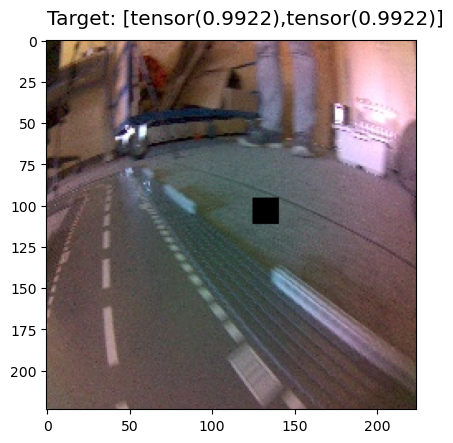

In [12]:
dataset = JetbotDataset(df, photos, train_transforms)
img, target = dataset[400]
display_image(img, target)

## Train-test-validation split

In [13]:
from sklearn.model_selection import train_test_split

train_size = 0.7
val_size = 0.15
test_size = 1 - (train_size + val_size)
batch_size = 64

train_indices, val_test_indices = train_test_split(df.index, test_size=val_size+test_size, stratify=df['left_class'])
val_indices, test_indices = train_test_split(val_test_indices, test_size=test_size/(val_size+test_size), stratify=df.loc[val_test_indices, 'left_class'])

print(df.loc[train_indices]['left_class'].value_counts())
print(df.loc[val_indices]['left_class'].value_counts())
print(df.loc[test_indices]['left_class'].value_counts())

df = df.drop(columns=['left_class'])

train_dataloader = DataLoader(
    JetbotDataset(
        df.iloc[train_indices],
        photos[train_indices],
        transforms=train_transforms
    ),
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = DataLoader(
    JetbotDataset(
        df.iloc[val_indices],
        photos[val_indices],
    ),
    batch_size=batch_size,
)

test_dataloader = DataLoader(
    JetbotDataset(
        df.iloc[test_indices],
        photos[test_indices],
    ),
    batch_size=batch_size,
)

left_class
 0    2941
-1    2368
 1    2367
Name: count, dtype: int64
left_class
 0    630
 1    508
-1    507
Name: count, dtype: int64
left_class
 0    631
-1    507
 1    507
Name: count, dtype: int64


## Training / Evaluation functions.

In [14]:
def train_model(
    model: nn.Module,
    epochs: int,
    trainloader: DataLoader,
    validloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_func: callable,
    model_save_path: str,
    force_cuda: bool = False,
):
    """
    Taken from https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/,
    feel free to change it
    """
    if force_cuda and torch.cuda.is_available():
        model.cuda()

    min_valid_loss = np.inf
    for e in range(epochs):
        train_loss = 0.0
        model.train()
        for data, labels in tqdm(trainloader):
            if force_cuda and torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()

            optimizer.zero_grad()
            target = model(data)
            loss = loss_func(target, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        valid_loss = 0.0
        model.eval()
        for data, labels in tqdm(validloader):
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()

            target = model(data)
            loss = loss_func(target, labels)
            valid_loss = loss.item() * data.size(0)

        print(
            f"Epoch {e+1} \t\t Training Loss: {train_loss / len(trainloader)} \t\t Validation Loss: {valid_loss / len(validloader)}"
        )
        
        if min_valid_loss > valid_loss:
            print(
                f"Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model"
            )
            min_valid_loss = valid_loss
            # Saving State Dict
            torch.save(model.state_dict(), model_save_path)

In [15]:
def evaluate_model(
    model: nn.Module,
    dataloader: DataLoader,
    loss_func: callable,
    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
):
    model.to(device)
    model.eval()

    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)

            outputs = model(data)
            loss = loss_func(outputs, labels)
            
            total_loss += loss.item() * data.size(0)
            total_samples += data.size(0)

    avg_loss = total_loss / total_samples
    return avg_loss

## Custom loss function

In [16]:
class CustomLoss(nn.Module):
    def __init__(self, device):
        super(CustomLoss, self).__init__()
        self.weights = torch.Tensor([1, 5]).to(device)

    def forward(self, predictions, targets):
        loss = torch.mean(self.weights * (predictions - targets) ** 2).to(device)
        return loss
    

device = torch.device('cuda')

## Exporting to ONNX

In [17]:
import onnxruntime as ort

input_t = torch.randint(0, 256, (1, 3, 224, 224), dtype=torch.float32)

def export_to_onnx(model_cls: type[nn.Module], pth_file: str, onnx_file: str):
    model = model_cls()
    model.load_state_dict(torch.load(pth_file))
    onnx_program = torch.onnx.export(model, input_t, onnx_file, opset_version=11)

def run_onnx_on_dummy_input(onnx_file: str):
    ort_sess = ort.InferenceSession(onnx_file)
    outputs = ort_sess.run(None, {'input.1': input_t.numpy()})

    # Print Result
    # predicted, actual = classes[outputs[0][0].argmax(0)], classes[y]
    # print(f'Predicted: "{predicted}", Actual: "{actual}"')
    return outputs

def export_to_onnx(model: nn.Module, pth_file: str, onnx_file: str, input_size: tuple):
    model.load_state_dict(torch.load(pth_file))
    model.eval()
    input_t = torch.randn(input_size).to(next(model.parameters()).device)

    torch.onnx.export(
        model, 
        input_t, 
        onnx_file, 
        opset_version=11, 
        input_names=['input'], 
        output_names=['output']
    )

## Model from the paper

In [21]:
class CustomNetwork(nn.Module):
    def __init__(self):
        super(CustomNetwork, self).__init__()
        
        # Normalization layer (input normalization)
        self.normalize = nn.BatchNorm2d(3)

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 24, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(24, 36, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(36, 48, kernel_size=5, stride=2)
        self.conv4 = nn.Conv2d(48, 64, kernel_size=3)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3)

        # Calculate the number of output neurons after the last convolutional layer
        self.flattened_size = self._get_flattened_size()

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)
        self.fc4 = nn.Linear(10, 2)

    def _get_flattened_size(self):
        # Helper function to calculate the number of neurons after convolutional layers
        with torch.no_grad():
            x = torch.zeros(1, 3, 224, 224)
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv3(x)
            x = self.conv4(x)
            x = self.conv5(x)
            return x.numel()

    def forward(self, x):
        x = self.normalize(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

# Testing the model with a sample input
model = CustomNetwork()
model = model.to(device)
print(model)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters:", num_params)

CustomNetwork(
  (normalize): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=28224, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=2, bias=True)
)
Number of trainable parameters: 2959436


In [19]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss = nn.MSELoss()

train_model(
    model,
    30,
    train_dataloader,
    val_dataloader,
    optimizer,
    loss,
    model_save_path=f"{MODELS_DIR}/ModelPaper.pth",
    force_cuda=True
)

  0%|          | 0/120 [00:00<?, ?it/s]d:\Environment\anaconda\envs\jetbot\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 26/26 [00:00<00:00, 41.43it/s]


Epoch 1 		 Training Loss: 0.4243711973230044 		 Validation Loss: 0.7536842788641269
Validation Loss Decreased(inf--->19.595791) 	 Saving The Model


100%|██████████| 26/26 [00:00<00:00, 41.95it/s]


Epoch 2 		 Training Loss: 0.31355344591041406 		 Validation Loss: 0.7402835499781829
Validation Loss Decreased(19.595791--->19.247372) 	 Saving The Model


100%|██████████| 26/26 [00:00<00:00, 41.02it/s]


Epoch 3 		 Training Loss: 0.3130901229878267 		 Validation Loss: 0.735738340478677
Validation Loss Decreased(19.247372--->19.129197) 	 Saving The Model


100%|██████████| 26/26 [00:00<00:00, 41.68it/s]


Epoch 4 		 Training Loss: 0.3131556387990713 		 Validation Loss: 0.7391121467718711


100%|██████████| 26/26 [00:00<00:00, 41.65it/s]


Epoch 5 		 Training Loss: 0.3131448687364658 		 Validation Loss: 0.7347530928941873
Validation Loss Decreased(19.129197--->19.103580) 	 Saving The Model


100%|██████████| 26/26 [00:00<00:00, 41.91it/s]


Epoch 6 		 Training Loss: 0.31311983689665795 		 Validation Loss: 0.7387055857823446


100%|██████████| 26/26 [00:00<00:00, 41.64it/s]


Epoch 7 		 Training Loss: 0.3131136933962504 		 Validation Loss: 0.7400542726883521


100%|██████████| 26/26 [00:00<00:00, 41.61it/s]


Epoch 8 		 Training Loss: 0.31310906559228896 		 Validation Loss: 0.7408860669686244


100%|██████████| 26/26 [00:00<00:00, 38.44it/s]


Epoch 9 		 Training Loss: 0.3130820749948422 		 Validation Loss: 0.7376565325718659


100%|██████████| 26/26 [00:00<00:00, 37.27it/s]


Epoch 10 		 Training Loss: 0.31306545113523804 		 Validation Loss: 0.7357592307604276


100%|██████████| 26/26 [00:00<00:00, 42.35it/s]


Epoch 11 		 Training Loss: 0.31307606200377147 		 Validation Loss: 0.7382350644240012


100%|██████████| 26/26 [00:00<00:00, 39.64it/s]


Epoch 12 		 Training Loss: 0.31311515408257645 		 Validation Loss: 0.7365900450027906


100%|██████████| 26/26 [00:00<00:00, 36.67it/s]


Epoch 13 		 Training Loss: 0.313068208967646 		 Validation Loss: 0.7400505588604853


100%|██████████| 26/26 [00:00<00:00, 41.65it/s]


Epoch 14 		 Training Loss: 0.3130627054721117 		 Validation Loss: 0.7402380555868149


100%|██████████| 26/26 [00:00<00:00, 39.35it/s]


Epoch 15 		 Training Loss: 0.31311786857744056 		 Validation Loss: 0.7367498943438897


100%|██████████| 26/26 [00:00<00:00, 41.62it/s]


Epoch 16 		 Training Loss: 0.31300035715103147 		 Validation Loss: 0.7439088133665231


100%|██████████| 26/26 [00:00<00:00, 41.54it/s]


Epoch 17 		 Training Loss: 0.3130425301690896 		 Validation Loss: 0.7412625046876761


100%|██████████| 26/26 [00:00<00:00, 41.66it/s]


Epoch 18 		 Training Loss: 0.3130124115695556 		 Validation Loss: 0.738362675675979


100%|██████████| 26/26 [00:00<00:00, 41.78it/s]


Epoch 19 		 Training Loss: 0.312978587175409 		 Validation Loss: 0.7367581988756473


100%|██████████| 26/26 [00:00<00:00, 40.47it/s]


Epoch 20 		 Training Loss: 0.3130256605645021 		 Validation Loss: 0.7407944076336347


100%|██████████| 26/26 [00:00<00:00, 41.10it/s]


Epoch 21 		 Training Loss: 0.3129960626363754 		 Validation Loss: 0.7395210289038144


100%|██████████| 26/26 [00:00<00:00, 37.12it/s]


Epoch 22 		 Training Loss: 0.312918529783686 		 Validation Loss: 0.7367808944903887


100%|██████████| 26/26 [00:01<00:00, 24.98it/s]


Epoch 23 		 Training Loss: 0.3129471360395352 		 Validation Loss: 0.7346244500233576
Validation Loss Decreased(19.103580--->19.100236) 	 Saving The Model


100%|██████████| 26/26 [00:01<00:00, 24.29it/s]


Epoch 24 		 Training Loss: 0.3129669858763615 		 Validation Loss: 0.7380709338646668


100%|██████████| 26/26 [00:01<00:00, 24.71it/s]


Epoch 25 		 Training Loss: 0.31296579266587893 		 Validation Loss: 0.7370676329502692


100%|██████████| 26/26 [00:01<00:00, 25.30it/s]


Epoch 26 		 Training Loss: 0.3129203476011753 		 Validation Loss: 0.7357923457255731


100%|██████████| 26/26 [00:01<00:00, 25.94it/s]


Epoch 27 		 Training Loss: 0.3128289078672727 		 Validation Loss: 0.7358818386609738


100%|██████████| 26/26 [00:00<00:00, 40.86it/s]


Epoch 28 		 Training Loss: 0.31281156092882156 		 Validation Loss: 0.7361921496116198


100%|██████████| 26/26 [00:00<00:00, 40.29it/s]


Epoch 29 		 Training Loss: 0.31275871420900025 		 Validation Loss: 0.7370201269021401


100%|██████████| 26/26 [00:00<00:00, 41.30it/s]


Epoch 30 		 Training Loss: 0.31269057244062426 		 Validation Loss: 0.7374280805771167


100%|██████████| 26/26 [00:00<00:00, 41.74it/s]


Epoch 31 		 Training Loss: 0.31271518928309283 		 Validation Loss: 0.7358809617849497


 90%|█████████ | 108/120 [00:08<00:00, 13.09it/s]


KeyboardInterrupt: 

In [27]:
model.load_state_dict(torch.load(f"{MODELS_DIR}/ModelPaperaugmentations_mse.pth"))

avg_loss = evaluate_model(model, test_dataloader, CustomLoss(device))
print(f"Test Loss: {avg_loss:.4f}")

Test Loss: 1.4599
